End to end test of our general network structure.  Will test on the known non-linear system $$\dot{x} = ax,$$ $$\dot{y} = b(x-x^2)+cy.$$  The Koopman operator for this system is $$\frac{d}{dt}\begin{bmatrix}z_1\\ z_2\\ z_3\end{bmatrix} = \begin{bmatrix} a & 0 & 0\\ b& c & -b\\ 0 & 0 & 2a\end{bmatrix}\begin{bmatrix}z_1\\ z_2\\ z_3\end{bmatrix}$$ where $$z_1 = x,$$ $$z_2 = y,$$ $$z_3 = x^{2}.$$

We will have to select $a,b$ and $c$ ahead of time and train for specific instances of them (equivilent to switching hamiltionians).  As long as $a$ and $c$ are both less than 0, this system will be stable.


In [84]:
import matplotlib.pyplot as plt         
import tensorflow as tf
import numpy as np
import scipy.integrate
import os

import sys
sys.path.append('..')
from utils import *
sys.path.remove('..')


#Some GPU configuration
#Always uses the 1st GPU avalible (if avalible) unless 1st line is uncommented, in which case no GPU is used

#tf.config.set_visible_devices([], 'GPU') #uncomment to set tensorflow to use CPU
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) != 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print('Warning: No GPU detected')

### $\phi$ and $\phi^{-1}$

In [38]:
STATE_DIMENSION = 3
ANTIKOOPMAN_DIMENSION = 2

#Train autoencoder on uniform distribution between -MAX_DIM_VALUE and MAX_DIM_VALUE
MAX_DIM_VALUE = 1.

#LecunUniform seems to give the most consistent results, 
#though the model still struggles to get started sometimes
INITILIZER = tf.keras.initializers.LecunUniform()


In [39]:
def generate_autoencoder_data(batch_size = 512):
    '''Generator for data when training the 
    autoencoder end-to-end
    '''
    koopman_dimension = 3
    triples = np.empty([batch_size, koopman_dimension])
    while True:
        for i in range(batch_size):
            z1, z2 = np.random.uniform(low=-MAX_DIM_VALUE, high=MAX_DIM_VALUE, size=2)
            z3 = z1*z1
            triples[i] = np.array([z1,z2,z3])

        yield (triples, triples)
        
def generate_encoder_data(batch_size = 4096):
    '''Generator to be used when training just
    the encoder (phi) on its own
    '''
    koopman_dimension = 3
    doubles = np.empty([batch_size, ANTIKOOPMAN_DIMENSION])
    triples = np.empty([batch_size, koopman_dimension])
    while True:
        for i in range(batch_size):
            z1, z2 = np.random.uniform(low=-MAX_DIM_VALUE, high=MAX_DIM_VALUE, size=2)
            z3 = z1*z1
            doubles[i] = np.array([z1,z2])
            triples[i] = np.array([z1, z2, z3])
        yield(triples, doubles)
        
def generate_decoder_data(batch_size = 4096):
    '''Generator to be used when training just the
    decoder (phi_inv) on its own
    '''
    doubles = np.empty([batch_size, ANTIKOOPMAN_DIMENSION])
    triples = np.empty([batch_size, STATE_DIMENSION])
    while True:
        for i in range(batch_size):
            z1, z2 = np.random.uniform(low=-MAX_DIM_VALUE, high=MAX_DIM_VALUE, size=2)
            z3 = z1*z1
            doubles[i] = np.array([z1,z2])
            triples[i]=np.array([z1,z2,z3])
        yield(doubles, triples)
        

In [40]:
#Input layers for the encoder and decoder, respectivley
initial_state = tf.keras.Input(shape = STATE_DIMENSION)
antikoop_state = tf.keras.Input(shape = ANTIKOOPMAN_DIMENSION)

##########################################ENCODER####################################################################
encoding_layer_1 = tf.keras.layers.Dense(32, activation="selu", name='encoding_layer_1', kernel_initializer = INITILIZER, bias_initializer = INITILIZER)(initial_state)
encoding_layer_2 = tf.keras.layers.Dense(64, activation="selu", name='encoding_layer_2', kernel_initializer = INITILIZER, bias_initializer = INITILIZER)(encoding_layer_1)
encoding_layer_3 = tf.keras.layers.Dense(128, activation="selu", name='encoding_layer_3', kernel_initializer = INITILIZER, bias_initializer = INITILIZER)(encoding_layer_2)
encoding_layer_4 = tf.keras.layers.Dense(32, activation="selu", name='encoding_layer_4', kernel_initializer=INITILIZER, bias_initializer=INITILIZER)(encoding_layer_3)
encoding_layer_5 = tf.keras.layers.Dense(8, activation="selu", name='encoding_layer_5', kernel_initializer=INITILIZER, bias_initializer=INITILIZER)(encoding_layer_4)
encoded_state = tf.keras.layers.Dense(ANTIKOOPMAN_DIMENSION, activation="selu", name='bottleneck', kernel_initializer = INITILIZER, bias_initializer = INITILIZER)(encoding_layer_5)
#####################################################################################################################

#########################################DECODER#####################################################################
decoding_layer_1 = tf.keras.layers.Dense(8, activation = "selu", name='decoding_layer_1', kernel_initializer = INITILIZER, bias_initializer = INITILIZER)(antikoop_state)
decoding_layer_2 = tf.keras.layers.Dense(32, activation = "selu", name='decoding_layer_2', kernel_initializer = INITILIZER, bias_initializer = INITILIZER)(decoding_layer_1)
decoding_layer_3 = tf.keras.layers.Dense(128, activation = "selu", name='decoding_layer_3', kernel_initializer = INITILIZER, bias_initializer = INITILIZER)(decoding_layer_2)
decoding_layer_4 = tf.keras.layers.Dense(64, activation = "selu", name='decoding_layer_4', kernel_initializer = INITILIZER, bias_initializer = INITILIZER)(decoding_layer_3)
decoding_layer_5 = tf.keras.layers.Dense(16, activation = "selu", name='decoding_layer_5', kernel_initializer = INITILIZER, bias_initializer = INITILIZER)(decoding_layer_4)
decoded_state = tf.keras.layers.Dense(STATE_DIMENSION, activation = "selu", name='decoded_layer', kernel_initializer = INITILIZER, bias_initializer = INITILIZER)(decoding_layer_5)
#####################################################################################################################



#Model declarations
#Autoencoder = tf.keras.Model(initial_state, decoded_state, name = 'Autoencoder')

Phi = tf.keras.Model(inputs=initial_state, outputs = encoded_state, name='Phi')
Phi_inv = tf.keras.Model(inputs = antikoop_state, outputs = decoded_state, name='Phi_inv')

Autoencoder = tf.keras.models.Sequential([Phi, Phi_inv], name='Autoencoder')


In [41]:
def autoencoding_loss(y_true, y_pred):
    '''The L2 norm of the input vector
    and the autoencoded vector
    Scale down to make gradients more tractable
    with large vectors?'''
    
    return tf.norm((y_true-y_pred), ord=2, axis=-1)
    
    #return tf.abs(y_true[0]-y_pred[0])/y_true[0] + tf.abs(y_true[1]-y_pred[1])/y_true[1] + tf.abs(y_true[2]-y_pred[2])/y_true[2]
    
    #return tf.abs(y_pred[0]*y_pred[0] - y_pred[2]) + tf.abs(y_true[0]-y_pred[0]) + tf.abs(y_true[1] - y_pred[1]) + tf.abs(y_true[2]-y_pred[2])

def encoder_loss(y_true, y_pred):
    return tf.norm(y_true-y_pred, ord=2, axis=-1)

def decoder_loss(y_true, y_pred):
    return tf.norm(y_true-y_pred, ord=2, axis=-1)# + 2*tf.abs(y_true[0]-y_pred[0]) + 2*tf.abs(y_true[1]-y_pred[1])



def predict_single_state(state, encoder = Phi, decoder = Phi_inv):
    '''Outputs the prediction of a single 
    state.  Primarily for sanity checks.
    '''
    encoded = encoder(np.array([state,]))
    decoded = decoder(encoder(np.array([state,]))).numpy()[0]
    L2_dist = np.linalg.norm(state-decoded, ord=2)


    print('Initial State:{}\nEncoded State:{}\nDecoded State:{}\nL2 Distance:{}\nInput z1 Squared:{}\nOutput z1 Squared:{}\nz3-z1^2:{}\nLoss:{}'.format(
            state, encoded.numpy(), decoded, L2_dist, state[0]*state[0],
            decoded[0]*decoded[0], decoded[2]-decoded[0]*decoded[0], 
            L2_dist + np.abs(decoded[2]-decoded[0]*decoded[0])))
          
    return None

In [38]:
Autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = .0001), loss=autoencoding_loss, metrics = ['mse', 'mae'], run_eagerly=False)

In [ ]:
history = Autoencoder.fit(generate_autoencoder_data(4096), steps_per_epoch=50,epochs=200)

In [44]:
z1, z2 = np.random.uniform(low=-MAX_DIM_VALUE, high=MAX_DIM_VALUE, size=2)
z3 = z1*z1

In [45]:
predict_single_state([z1,z2,z3])

Initial State:[0.9243560804077946, 0.5264566119193492, 0.8544341633868613]
Encoded State:[[3.2015438 2.0227363]]
Decoded State:[0.92487115 0.524776   0.8517084 ]
L2 Distance:0.003243382525888447
Input z1 Squared:0.8544341633868613
Output z1 Squared:0.8553866147994995
z3-z1^2:-0.0036782026290893555
Loss:0.006921585154977802


In [41]:
Autoencoder.save('./models/trial0e400.h5')

In [28]:
write_history(history, [Phi, Phi_inv, Autoencoder], datadir='./trials/', batch_size=4096)

'./trials/trial0.data'

In [40]:
append_history(history, 0, datadir='./trials/', params={'Learning Rate':.0001})

In [128]:
Phi.save('./models/Phi.h5')

### Nonlinear evolution function

In [46]:
#Configure and set up koopman operator
#These parameters keep z1 and z2 within +/-100 from t=0.0 to t=10.0 provided z1 and z2 are between 0 and 1 at t=0.0
system_a = -0.3
system_b = 0.1
system_c = -0.1
koopman_operator = np.array([[system_a, 0, 0], [system_b, system_c, -system_b], [0, 0, 2*system_a]])

In [47]:
def koopman_evolve(t, y):
    return np.matmul(koopman_operator, y)

        
def generate_dynamical_system_data(batch_size = 128, t_span = 10.0):
    koopman_dimension = 3
    systems = np.empty([batch_size, koopman_dimension])
    initial_conditions = np.empty([batch_size, koopman_dimension])
    while True:
        for i in range(batch_size):
            y0 = np.random.random(3)
            y0[2] = 1/y0[0]
            evolved = []
            evolution = scipy.integrate.solve_ivp(koopman_evolve, y0, (0, t_span)).y
            for k in evolution:
                evolved.append(k[-1])
            systems[i] = evolved
            initial_conditions[i] = y0
        
        yield (initial_conditions, systems)
         
    
    
#Idealized phi and phi_inv, gives an upper bound on accuracy of 
#nonlinear network
def ideal_compression(state):
    return np.array([state[0], state[1]])

def ideal_decompression(state):
    return np.array([state[0], state[1], state[0]*state[0]])

#Generator which pre-applies perfect compression and decompression on system
def generate_ideal_system_data(batch_size = 128, t_span=1.0):
    systems = np.empty([batch_size, ANTIKOOPMAN_DIMENSION])
    initial_conditions = np.empty([batch_size, ANTIKOOPMAN_DIMENSION])
    while True:
        for i in range(batch_size):
            y0 = np.empty([STATE_DIMENSION])
            y0[0], y0[1] = 2.*np.random.random(2)
            y0[2] = y0[0]*y0[0] 
            #y0.reshape(3,1)
            evolution = scipy.integrate.solve_ivp(koopman_evolve,(0,t_span), y0).y[:,-1]
            initial_conditions[i] = ideal_compression(y0)
            systems[i] = ideal_compression(evolution)
        yield(initial_conditions, systems)
        
        
def predict_single_point(y0):
    return NonlinearF(np.array([y0,])).numpy()[0]
        

def nonlinear_loss(y_true, y_pred):
    return tf.norm(y_true-y_pred, ord=2, axis=-1)


def read_dynamical_system_data(datadir='./evolutions/', pre_compress=True):
    pre_evolution = []
    post_evolution = []
    
    for i in range(len(os.listdir(datadir))):
        with open(datadir+'evolution{}.csv'.format(i), 'r') as f:
            data = [x.strip().split(',')[1:] for x in f.readlines()]
            data = [[float(y) for y in x] for x in data]
            
            if pre_compress:
                data = [ideal_compression(x) for x in data]
            
            pre_evolution.append(data[0])
            
            for k in data[1:-1]:
                pre_evolution.append(k)
                post_evolution.append(k)
            
            post_evolution.append(data[-1])
            
    ds = tf.data.Dataset.from_tensor_slices((pre_evolution, post_evolution))
    
    return ds.shuffle(100000, reshuffle_each_iteration=True)


In [61]:
#Change reading function so that we take in x number of evolutions for test, rather than x number of points
train_data = read_dynamical_system_data('./evolutions/50randscap1_dt0p01/')
val_data = train_data.skip(int(0.8*100000)).batch(int(0.2*100000))
train_data = train_data.take(int(0.8*100000)).batch(int(0.8*100000))

In [62]:
inputs = tf.keras.layers.Input(ANTIKOOPMAN_DIMENSION)

nonlinear_layer_1 = tf.keras.layers.Dense(32, activation='selu', name='nonlinea_layer_1')(inputs)
nonlinear_layer_2 = tf.keras.layers.Dense(64, activation='selu', name='nonlinear_layer_2')(nonlinear_layer_1)
nonlinear_layer_3 = tf.keras.layers.Dense(128, activation='selu', name='nonlinear_layer_3')(nonlinear_layer_2)
nonlinear_layer_4 = tf.keras.layers.Dense(64, activation='selu', name='nonlinear_layer_4')(nonlinear_layer_3)
nonlinear_layer_5 = tf.keras.layers.Dense(16, activation='selu', name='nonlinear_layer_5')(nonlinear_layer_4)
evolved = tf.keras.layers.Dense(ANTIKOOPMAN_DIMENSION, activation='selu', name='evolved_state_layer')(nonlinear_layer_5)

NonlinearF = tf.keras.models.Model(inputs=inputs, outputs=evolved)

In [76]:
NonlinearF.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.0001), loss=nonlinear_loss)

In [ ]:
history = NonlinearF.fit(train_data,validation_data=val_data, epochs=750)

In [85]:
write_history(history, NonlinearF, datadir='evolutiontrials/', batch_size=100000, other_info={'dataset':})

'evolutiontrials/trial4.data'

In [86]:
append_history(history, 4, datadir='./evolutiontrials/', params={'Learning Rate':.0001})

[0.2716656562833525, 0.649699985331584, 0.07380222880386461]


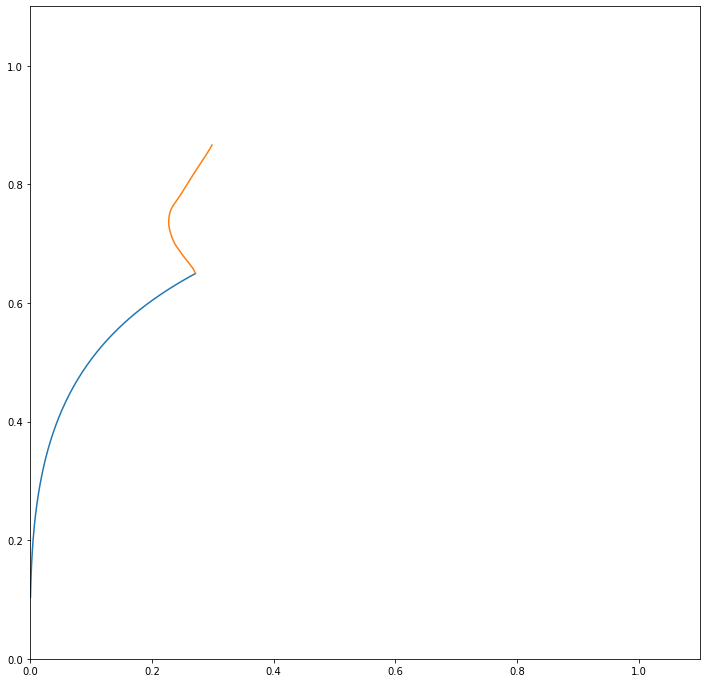

In [83]:
def plot_test_case(initial_conds=[], random=True):
    if random==True or initial_conds==[]:
        initial_conds = [0.,0.,0.]
        initial_conds[0], initial_conds[1] = np.random.random(2)
        initial_conds[2] = initial_conds[0]*initial_conds[0]
    
    evolution = scipy.integrate.solve_ivp(koopman_evolve, (0.,20.), initial_conds, rtol=1e-11,atol=1e-12).y



    learned_evolution = [[], []]
    learned_evolution[0].append(initial_conds[0])
    learned_evolution[1].append(initial_conds[1])

    for i in range(1000):
        new = NonlinearF(np.array([[learned_evolution[0][-1], learned_evolution[1][-1]]])).numpy()[0]
        learned_evolution[0].append(new[0])
        learned_evolution[1].append(new[1])



    fig, ax = plt.subplots(1,1, figsize = (12,12))

    ax.set_xlim([0.,1.1])
    ax.set_ylim([0.,1.1])

    ax.plot(evolution[0], evolution[1])
    ax.plot(learned_evolution[0],learned_evolution[1] )
    print(initial_conds)

    
plot_test_case(random=True)

## Derivation of the Koopman Operator

We start with $$\dot{x} = ax,$$ $$\dot{y} = b(x-x^2)+cy.$$  We start by converting our existing variables, $x$ and $y$, into $z$'s.  This gives
$$z_1 = x\qquad \dot{z_1} = \dot{x} = ax = az_1$$
and
$$z_2 = y\qquad \dot{z_2} = \dot{y} = b(x-x^2)+cy = b(z_1-z_3)+cz_2$$
Here, since $x^2$ is a nonlinear term, we had to introduce a linear term to replace it.  This leads to
$$z_3 = x^2\qquad \dot{z_3} = 2x\dot{x} = 2ax^{2} = 2az_3$$
All of our original variables have been accounted for, and all of our $z$'s have their derivates described using only linear terms.  By simply putting this together into a matrix, we have our Koopman operator.

We can easily see that $(x,y)=(0,0)$ is a fixed point of this system.  We evaluate the Jacobian of the system (in the nonlinear representation) at the fixed point, giving 
$$\left.\begin{bmatrix}a&0\\ b-2bx&c\end{bmatrix}\right|_{(x,y)=(0,0)}=\begin{bmatrix}a&0\\ b&c\end{bmatrix}.$$
The eigenvalues of this matrix are clearly $a$ and $c$.  Then as long as $a$ and $c$ are both negative, the system should be stable near $x_0$.

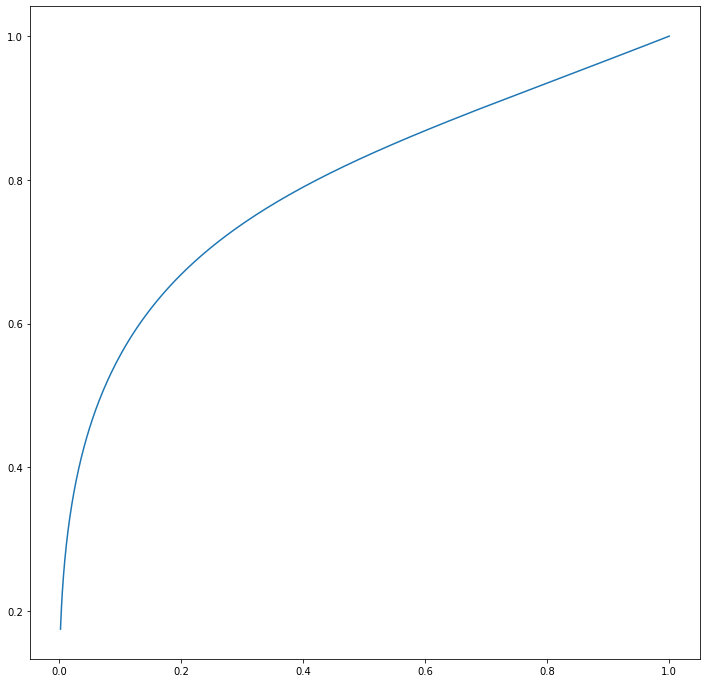

In [58]:
a = -0.3
b = 0.1
c = -0.1

def dym_system(t, y):
    return [a*y[0], b*(y[0]-y[0]*y[0])+c*y[1]]

curve = scipy.integrate.solve_ivp(dym_system, (0.0, 20.0), (1.,1.), rtol=1e-11, atol=1e-12)

fig, ax = plt.subplots(figsize=(12,12))

ax.plot(curve.y[0], curve.y[1])

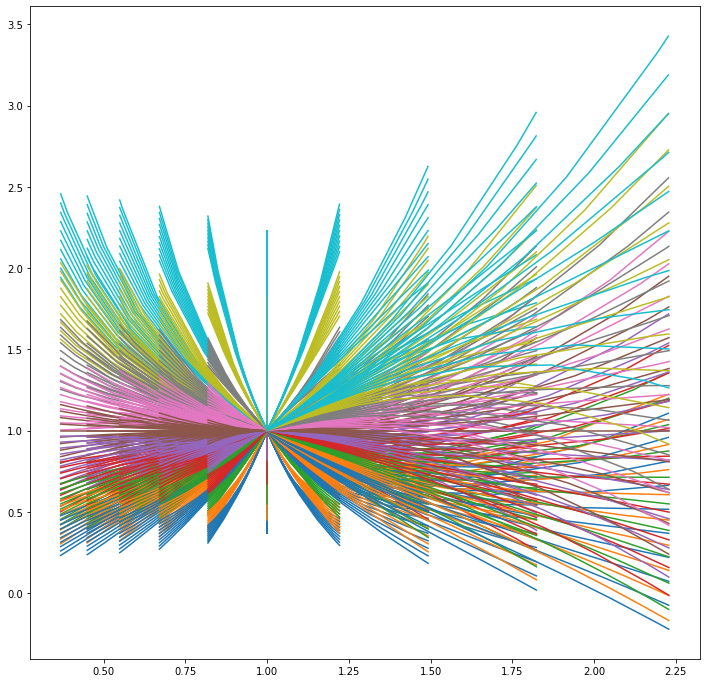

In [6]:
fig, ax = plt.subplots(1,1, figsize = (12,12))


for i in range(-5,5):
    for k in range(-5,5):
        for j in range(-5,5):
            a = 0.2*i
            b = 0.2*k
            c = 0.2*j
            curve = scipy.integrate.solve_ivp(dym_system, (0.,1.), (1.,1.), method='BDF')
            ax.plot(curve.y[0], curve.y[1], label=r'$a={:.1f}, b={:.1f}$'.format(0.2*i, 0.2*k))
        
#ax.legend()